In [42]:
import os
import numpy
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np

In [43]:
df = pd.read_csv("../data/metadata/reference.csv")

In [44]:
nd = np.random.rand(len(df))

In [45]:
df.head()

,PatientID,probCOVID,probSevere
0,8622,1,0
1,1072,1,0
2,10456,1,0
3,2063,1,0
4,9448,1,0


In [46]:
df_train = df[nd < 0.8].reset_index(drop=True)
df_val = df[(0.8 <= nd) & (nd < 0.9)].reset_index(drop=True)
df_test = df[0.9 <= nd].reset_index(drop=True)

# Visualization

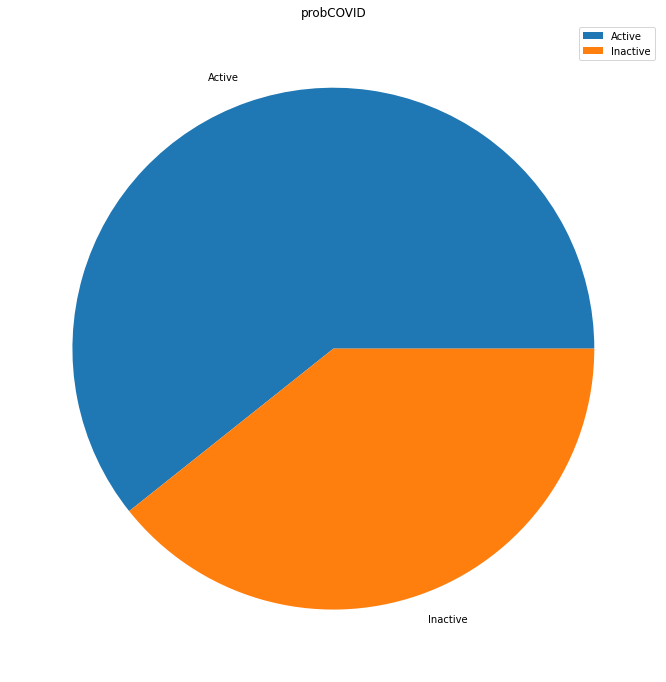

In [47]:
values = df_train.probCOVID.value_counts()
labels = ['Active', 'Inactive']
plt.figure(figsize=(16, 12))
plt.pie(values, labels = labels)
plt.legend()
plt.title("probCOVID")
plt.show() 

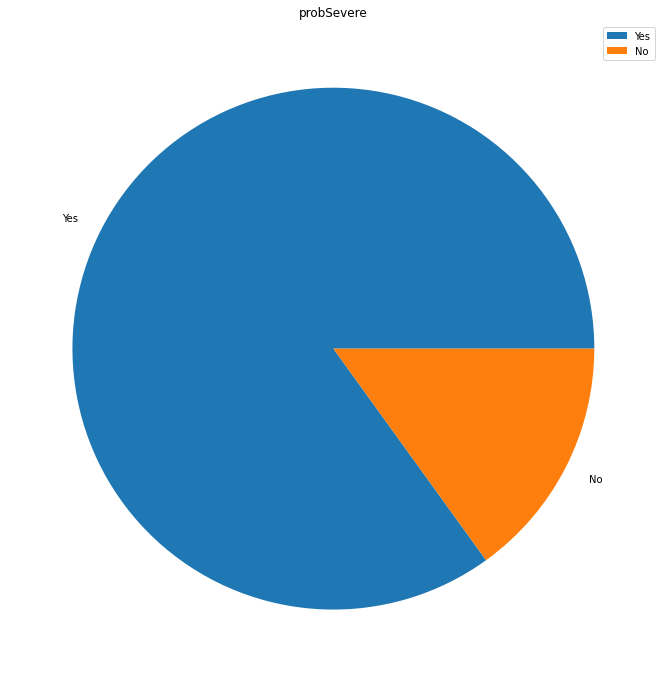

In [48]:
values = df_train.probSevere.value_counts()
labels = ['Yes', 'No']
plt.figure(figsize=(16, 12))
plt.pie(values, labels = labels)
plt.legend()
plt.title("probSevere")
plt.show() 

In [49]:
import numpy as np
import SimpleITK as sitk
from typing import Iterable
def clip_and_normalize(np_image: np.ndarray,
                       clip_min: int = -1100,
                       clip_max: int = 300
                       ) -> np.ndarray:
    np_image = np.clip(np_image, clip_min, clip_max)
    np_image = (np_image - clip_min) / (clip_max - clip_min)
    return np_image


def resample(itk_image: sitk.Image,
             new_spacing: Iterable[float],
             outside_val: float = 0
             ) -> sitk.Image:

    shape = itk_image.GetSize()
    spacing = itk_image.GetSpacing()
    output_shape = tuple(int(round(s * os / ns)) for s, os, ns in zip(shape, spacing, new_spacing))
    return sitk.Resample(
        itk_image,
        output_shape,
        sitk.Transform(),
        sitk.sitkLinear,
        itk_image.GetOrigin(),
        new_spacing,
        itk_image.GetDirection(),
        outside_val,
        sitk.sitkFloat32,
    )

def center_crop(np_image: np.ndarray,
                new_shape: Iterable[int],
                outside_val: float = 0
                ) -> np.ndarray:
    output_image = np.full(new_shape, outside_val, np_image.dtype)

    slices = tuple()
    offsets = tuple()
    for it, sh in enumerate(new_shape):
        size = sh // 2
        if it == 0:
            center = np_image.shape[it] - size
        else:
            center = (np_image.shape[it] // 2)
        start = center - size
        stop = center + size + (sh % 2)

        # computing what area of the original image will be in the cropped output
        slce = slice(max(0, start), min(np_image.shape[it], stop))
        slices += (slce,)

        # computing offset to pad if the crop is partly outside of the scan
        offset = slice(-min(0, start), 2 * size - max(0, (start + 2 * size) - np_image.shape[it]))
        offsets += (offset,)

    output_image[offsets] = np_image[slices]

    return output_image


def preprocess(input_image: sitk.Image,
               new_spacing: Iterable[float] = (1.6, 1.6, 1.6),
               new_shape: Iterable[int] = (240, 240, 240),
               ) -> np.ndarray:

    input_image = resample(input_image, new_spacing=new_spacing)
    input_image = sitk.GetArrayFromImage(input_image)
    input_image = center_crop(input_image, new_shape=new_shape)
    input_image = clip_and_normalize(input_image)
    return input_image

def show(im, title):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(im[im.shape[0] // 2, :, :])
        ax2.imshow(im[:, im.shape[1] // 2, :])
        ax3.imshow(im[:, :, im.shape[2] // 2])
        plt.title(title)
        plt.show()
        
def visualization(image_path):    
    input_image = sitk.ReadImage(image_path)
    input_image = resample(input_image, new_spacing=(1.6, 1.6, 1.6))
    input_image = sitk.GetArrayFromImage(input_image)
    input_image = center_crop(input_image, new_shape=(240, 240, 240))
    input_image = clip_and_normalize(input_image)
    show(input_image, 'clipped')

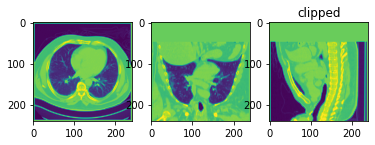

probCOVID: 1
probSevere: 0
**************************************************


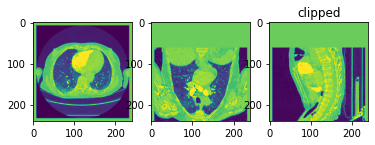

probCOVID: 1
probSevere: 0
**************************************************


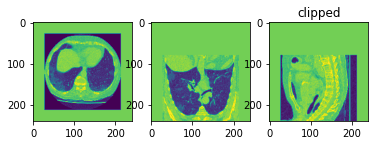

probCOVID: 1
probSevere: 0
**************************************************


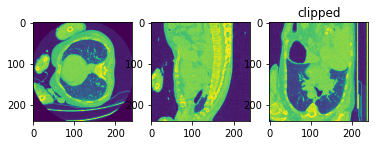

probCOVID: 0
probSevere: 0
**************************************************


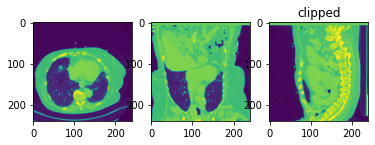

probCOVID: 1
probSevere: 0
**************************************************


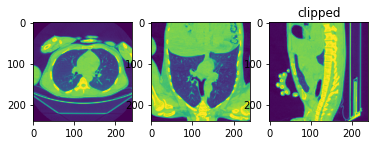

probCOVID: 0
probSevere: 0
**************************************************


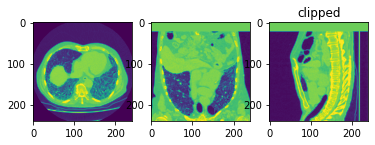

probCOVID: 0
probSevere: 0
**************************************************


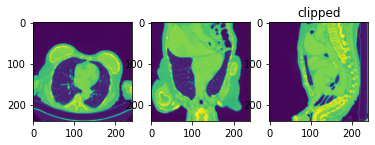

probCOVID: 0
probSevere: 0
**************************************************


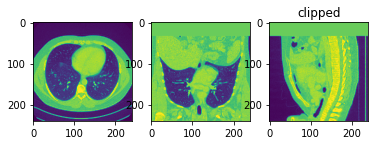

probCOVID: 0
probSevere: 0
**************************************************


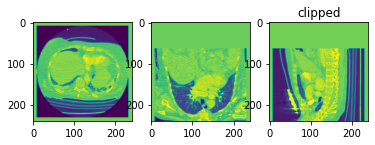

probCOVID: 1
probSevere: 0
**************************************************


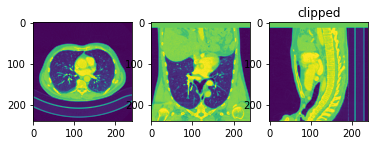

probCOVID: 0
probSevere: 0
**************************************************


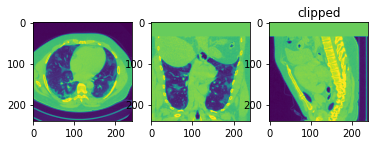

probCOVID: 1
probSevere: 0
**************************************************


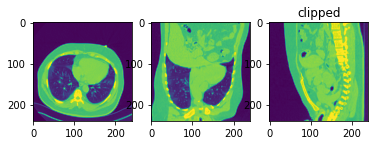

probCOVID: 1
probSevere: 0
**************************************************


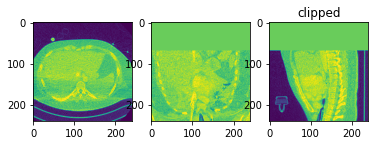

probCOVID: 1
probSevere: 1
**************************************************


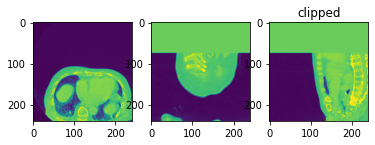

probCOVID: 0
probSevere: 0
**************************************************


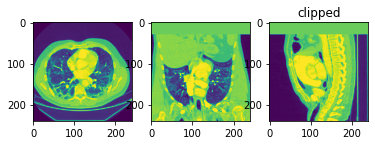

probCOVID: 1
probSevere: 0
**************************************************


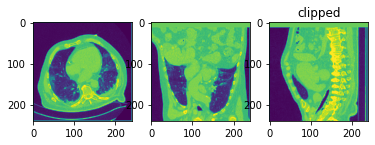

probCOVID: 1
probSevere: 0
**************************************************


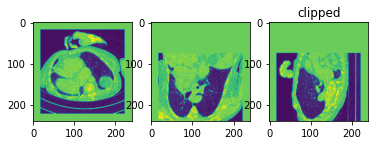

probCOVID: 1
probSevere: 0
**************************************************


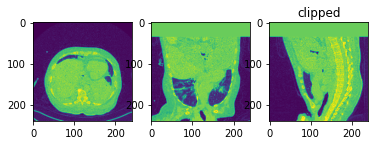

probCOVID: 1
probSevere: 1
**************************************************


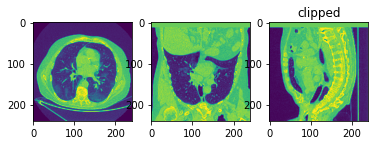

probCOVID: 0
probSevere: 0
**************************************************


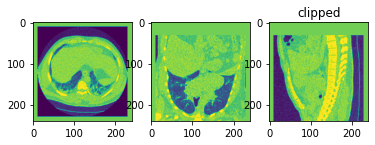

probCOVID: 1
probSevere: 0
**************************************************


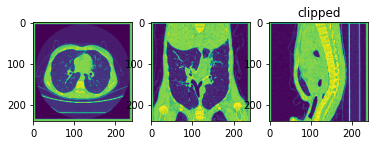

probCOVID: 1
probSevere: 0
**************************************************


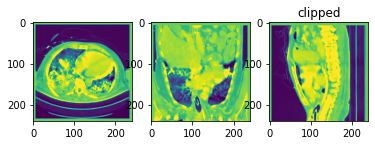

probCOVID: 1
probSevere: 1
**************************************************


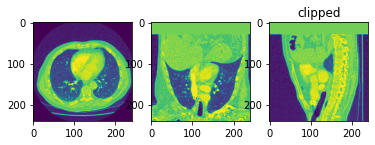

probCOVID: 0
probSevere: 0
**************************************************


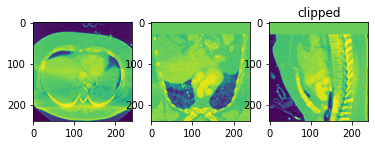

probCOVID: 1
probSevere: 1
**************************************************


In [50]:
for i in np.random.randint(len(df_train), size=25):
    image_name, probCOVID, probSevere = df_train.iloc[i]
    image_path = "../data/mha/" + str(image_name) + ".mha"
    visualization(image_path)
    print(f"probCOVID: {probCOVID}")
    print(f"probSevere: {probSevere}")
    print("*"*50)

# Data Processing

In [51]:
import torch.utils.data as data
import torch
from utils import to_input_format

In [52]:
def data_processing(df):
    input_images = []
    labels_1 = []
    labels_2 = []
    for i in range(len(df)):
        (file_name, label_1, label_2) = df[i]
        image_path = "../data/mha/" + str(file_name) + '.mha'
        input_image = sitk.ReadImage(image_path)        
        input_image = resample(input_image, new_spacing=(1.6, 1.6, 1.6))
        input_image = sitk.GetArrayFromImage(input_image)
        input_image = center_crop(input_image, new_shape=(240, 240, 240))
        input_image = clip_and_normalize(input_image)
        input_image = to_input_format(input_image)             
        input_images.append(torch.tensor(input_image))
        labels_1.append(torch.tensor(label_1))
        labels_2.append(torch.tensor(label_2))
    input_images = torch.concat(input_images)
    labels_1 = torch.tensor(labels_1)
    labels_2 = torch.tensor(labels_2)
    return input_images, labels_1, labels_2

In [60]:
train_loader = data.DataLoader(
    dataset=df_train.values[:4],
    batch_size=4,
    shuffle=True,
    num_workers=4,
    prefetch_factor=4,
    collate_fn=data_processing
)
val_loader = data.DataLoader(
    dataset=df_val.values[:4],
    batch_size=4,
    shuffle=True,
    num_workers=4,
    prefetch_factor=4,
    collate_fn=data_processing
)
test_loader = data.DataLoader(
    dataset=df_test.values,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    prefetch_factor=4,
    collate_fn=data_processing
)

# Model

In [61]:
from pytorch_lightning import Trainer

In [67]:
# Altered from https://github.com/hassony2/kinetics_i3d_pytorch
import math
import os
from pytorch_lightning import LightningModule
import numpy as np
import torch
import torchmetrics
import torch.nn.functional as F

train_auc1   = torchmetrics.AUROC(pos_label=1)
train_auc2   = torchmetrics.AUROC(pos_label=1)
val_auc1     = torchmetrics.AUROC(pos_label=1)
val_auc2     = torchmetrics.AUROC(pos_label=1)
test_auc1    = torchmetrics.AUROC(pos_label=1)
test_auc2    = torchmetrics.AUROC(pos_label=1)


def calc_prob(logits):
    return F.softmax(logits, dim=1)[:,1]


def get_padding_shape(filter_shape, stride):
    def _pad_top_bottom(filter_dim, stride_val):
        pad_along = max(filter_dim - stride_val, 0)
        pad_top = pad_along // 2
        pad_bottom = pad_along - pad_top
        return pad_top, pad_bottom

    padding_shape = []
    for filter_dim, stride_val in zip(filter_shape, stride):
        pad_top, pad_bottom = _pad_top_bottom(filter_dim, stride_val)
        padding_shape.append(pad_top)
        padding_shape.append(pad_bottom)
    depth_top = padding_shape.pop(0)
    depth_bottom = padding_shape.pop(0)
    padding_shape.append(depth_top)
    padding_shape.append(depth_bottom)

    return tuple(padding_shape)


def simplify_padding(padding_shapes):
    all_same = True
    padding_init = padding_shapes[0]
    for pad in padding_shapes[1:]:
        if pad != padding_init:
            all_same = False
    return all_same, padding_init


class Unit3Dpy(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=(1, 1, 1),
                 stride=(1, 1, 1),
                 activation='relu',
                 padding='SAME',
                 use_bias=False,
                 use_bn=True):
        super(Unit3Dpy, self).__init__()

        self.padding = padding
        self.activation = activation
        self.use_bn = use_bn
        if padding == 'SAME':
            padding_shape = get_padding_shape(kernel_size, stride)
            simplify_pad, pad_size = simplify_padding(padding_shape)
            self.simplify_pad = simplify_pad
        elif padding == 'VALID':
            padding_shape = 0
        else:
            raise ValueError(
                'padding should be in [VALID|SAME] but got {}'.format(padding))

        if padding == 'SAME':
            if not simplify_pad:
                self.pad = torch.nn.ConstantPad3d(padding_shape, 0)
                self.conv3d = torch.nn.Conv3d(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride=stride,
                    bias=use_bias)
            else:
                self.conv3d = torch.nn.Conv3d(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride=stride,
                    padding=pad_size,
                    bias=use_bias)
        elif padding == 'VALID':
            self.conv3d = torch.nn.Conv3d(
                in_channels,
                out_channels,
                kernel_size,
                padding=padding_shape,
                stride=stride,
                bias=use_bias)
        else:
            raise ValueError(
                'padding should be in [VALID|SAME] but got {}'.format(padding))

        if self.use_bn:
            self.batch3d = torch.nn.BatchNorm3d(out_channels)

        if activation == 'relu':
            self.activation = torch.nn.functional.relu

    def forward(self, inp):
        if self.padding == 'SAME' and self.simplify_pad is False:
            inp = self.pad(inp)
        out = self.conv3d(inp)
        if self.use_bn:
            out = self.batch3d(out)
        if self.activation is not None:
            out = torch.nn.functional.relu(out)
        return out


class MaxPool3dTFPadding(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding='SAME'):
        super(MaxPool3dTFPadding, self).__init__()
        if padding == 'SAME':
            padding_shape = get_padding_shape(kernel_size, stride)
            self.padding_shape = padding_shape
            self.pad = torch.nn.ConstantPad3d(padding_shape, 0)
        self.pool = torch.nn.MaxPool3d(kernel_size, stride, ceil_mode=True)

    def forward(self, inp):
        inp = self.pad(inp)
        out = self.pool(inp)
        return out


class Mixed(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Mixed, self).__init__()
        # Branch 0
        self.branch_0 = Unit3Dpy(
            in_channels, out_channels[0], kernel_size=(1, 1, 1))

        # Branch 1
        branch_1_conv1 = Unit3Dpy(
            in_channels, out_channels[1], kernel_size=(1, 1, 1))
        branch_1_conv2 = Unit3Dpy(
            out_channels[1], out_channels[2], kernel_size=(3, 3, 3))
        self.branch_1 = torch.nn.Sequential(branch_1_conv1, branch_1_conv2)

        # Branch 2
        branch_2_conv1 = Unit3Dpy(
            in_channels, out_channels[3], kernel_size=(1, 1, 1))
        branch_2_conv2 = Unit3Dpy(
            out_channels[3], out_channels[4], kernel_size=(3, 3, 3))
        self.branch_2 = torch.nn.Sequential(branch_2_conv1, branch_2_conv2)

        # Branch3
        branch_3_pool = MaxPool3dTFPadding(
            kernel_size=(3, 3, 3), stride=(1, 1, 1), padding='SAME')
        branch_3_conv2 = Unit3Dpy(
            in_channels, out_channels[5], kernel_size=(1, 1, 1))
        self.branch_3 = torch.nn.Sequential(branch_3_pool, branch_3_conv2)

    def forward(self, inp):
        out_0 = self.branch_0(inp)
        out_1 = self.branch_1(inp)
        out_2 = self.branch_2(inp)
        out_3 = self.branch_3(inp)
        out = torch.cat((out_0, out_1, out_2, out_3), 1)
        return out


class I3D(LightningModule):
    def __init__(self,
                 input_channels=3,
                 nr_outputs=2,
                 modality='rgb',
                 dropout_prob=0,
                 name='inception',
                 pre_trained=False,
                 pre_trained_path='./algorithm/i3d/model_rgb.pth',
                 lr=1e-3):
        super(I3D, self).__init__()
        self.lr = lr
        self.name = name
        self.input_channels = input_channels
        if modality == 'rgb':
            in_channels = 3
        elif modality == 'flow':
            in_channels = 2
        else:
            raise ValueError(
                '{} not among known modalities [rgb|flow]'.format(modality))
        if in_channels != input_channels:
            raise ValueError("Modality "+str(modality)+' does not correspond to input_channels '+str(input_channels) +
                             '. input_channels should be: '+str(3 if modality == 'rgb' else 2))
        self.modality = modality

        conv3d_1a_7x7 = Unit3Dpy(
            out_channels=64,
            in_channels=in_channels,
            kernel_size=(7, 7, 7),
            stride=(2, 2, 2),
            padding='SAME')
        # 1st conv-pool
        self.conv3d_1a_7x7 = conv3d_1a_7x7
        self.maxPool3d_2a_3x3 = MaxPool3dTFPadding(
            kernel_size=(1, 3, 3), stride=(1, 2, 2), padding='SAME')
        # conv conv
        conv3d_2b_1x1 = Unit3Dpy(
            out_channels=64,
            in_channels=64,
            kernel_size=(1, 1, 1),
            padding='SAME')
        self.conv3d_2b_1x1 = conv3d_2b_1x1
        conv3d_2c_3x3 = Unit3Dpy(
            out_channels=192,
            in_channels=64,
            kernel_size=(3, 3, 3),
            padding='SAME')
        self.conv3d_2c_3x3 = conv3d_2c_3x3
        self.maxPool3d_3a_3x3 = MaxPool3dTFPadding(
            kernel_size=(1, 3, 3), stride=(1, 2, 2), padding='SAME')

        # Mixed_3b
        self.mixed_3b = Mixed(192, [64, 96, 128, 16, 32, 32])
        self.mixed_3c = Mixed(256, [128, 128, 192, 32, 96, 64])

        self.maxPool3d_4a_3x3 = MaxPool3dTFPadding(
            kernel_size=(3, 3, 3), stride=(2, 2, 2), padding='SAME')

        # Mixed 4
        self.mixed_4b = Mixed(480, [192, 96, 208, 16, 48, 64])
        self.mixed_4c = Mixed(512, [160, 112, 224, 24, 64, 64])
        self.mixed_4d = Mixed(512, [128, 128, 256, 24, 64, 64])
        self.mixed_4e = Mixed(512, [112, 144, 288, 32, 64, 64])
        self.mixed_4f = Mixed(528, [256, 160, 320, 32, 128, 128])

        self.maxPool3d_5a_2x2 = MaxPool3dTFPadding(
            kernel_size=(2, 2, 2), stride=(2, 2, 2), padding='SAME')

        # Mixed 5
        self.mixed_5b = Mixed(832, [256, 160, 320, 32, 128, 128])
        self.mixed_5c = Mixed(832, [384, 192, 384, 48, 128, 128])

        self.avg_pool = torch.nn.AvgPool3d((2, 7, 7), (1, 1, 1))
        self.dropout = torch.nn.Dropout(dropout_prob)

        # set original final layer to original 400 classes
        self.conv3d_0c_1x1 = Unit3Dpy(
            in_channels=1024,
            out_channels=400,
            kernel_size=(1, 1, 1),
            activation=None,
            use_bias=True,
            use_bn=False)

        if pre_trained:
            self.load_state_dict(torch.load(pre_trained_path))

        # add new final linear layer to replace the original one
        self.linear1 = torch.nn.Linear(1024, nr_outputs)
        self.linear2 = torch.nn.Linear(1024, nr_outputs)

    def forward(self, inp):
        if self.input_channels == 3 and inp.shape[1] == 1:
            inp = inp.expand(-1, 3, -1, -1, -1)

        out = self.conv3d_1a_7x7(inp)
        out = self.maxPool3d_2a_3x3(out)
        out = self.conv3d_2b_1x1(out)
        out = self.conv3d_2c_3x3(out)
        out = self.maxPool3d_3a_3x3(out)
        out = self.mixed_3b(out)
        out = self.mixed_3c(out)
        out = self.maxPool3d_4a_3x3(out)
        out = self.mixed_4b(out)
        out = self.mixed_4c(out)
        out = self.mixed_4d(out)
        out = self.mixed_4e(out)
        out = self.mixed_4f(out)
        out = self.maxPool3d_5a_2x2(out)
        out = self.mixed_5b(out)
        out = self.mixed_5c(out)
        out = self.avg_pool(out)
        out = self.dropout(out)

        out = out.mean(dim=[2, 3, 4])
        out1 = self.linear1(out)
        out2 = self.linear2(out)
        return out1, out2

    def load_tf_weights(self, sess):
        state_dict = {}
        if self.modality == 'rgb':
            prefix = 'RGB/inception_i3d'
        elif self.modality == 'flow':
            prefix = 'Flow/inception_i3d'
        load_conv3d(state_dict, 'conv3d_1a_7x7', sess,
                    os.path.join(prefix, 'Conv3d_1a_7x7'))
        load_conv3d(state_dict, 'conv3d_2b_1x1', sess,
                    os.path.join(prefix, 'Conv3d_2b_1x1'))
        load_conv3d(state_dict, 'conv3d_2c_3x3', sess,
                    os.path.join(prefix, 'Conv3d_2c_3x3'))

        load_mixed(state_dict, 'mixed_3b', sess,
                   os.path.join(prefix, 'Mixed_3b'))
        load_mixed(state_dict, 'mixed_3c', sess,
                   os.path.join(prefix, 'Mixed_3c'))
        load_mixed(state_dict, 'mixed_4b', sess,
                   os.path.join(prefix, 'Mixed_4b'))
        load_mixed(state_dict, 'mixed_4c', sess,
                   os.path.join(prefix, 'Mixed_4c'))
        load_mixed(state_dict, 'mixed_4d', sess,
                   os.path.join(prefix, 'Mixed_4d'))
        load_mixed(state_dict, 'mixed_4e', sess,
                   os.path.join(prefix, 'Mixed_4e'))
        # Here goest to 0.1 max error with tf
        load_mixed(state_dict, 'mixed_4f', sess,
                   os.path.join(prefix, 'Mixed_4f'))

        load_mixed(
            state_dict,
            'mixed_5b',
            sess,
            os.path.join(prefix, 'Mixed_5b'),
            fix_typo=True)
        load_mixed(state_dict, 'mixed_5c', sess,
                   os.path.join(prefix, 'Mixed_5c'))
        load_conv3d(
            state_dict,
            'conv3d_0c_1x1',
            sess,
            os.path.join(prefix, 'Logits', 'Conv3d_0c_1x1'),
            bias=True,
            bn=False)
        self.load_state_dict(state_dict)
        
    def training_step(self, batch):
        x, l1, l2 = batch
        logits1, logits2 = self(x)
        loss = F.cross_entropy(logits1, l1) + F.cross_entropy(logits2, l2)
        self.log("train/loss", loss, sync_dist=True)
        
        train_auc1.update(calc_prob(logits1), l1)
        train_auc2.update(calc_prob(logits2), l2)
        
        return loss
    
    def training_epoch_end(self, _):
        auc1 = train_auc1.compute()
        auc2 = train_auc2.compute()
        train_auc1.reset()
        train_auc2.reset()
        self.log("train/auc1", auc1, sync_dist=True)
        self.log("train/auc2", auc2, sync_dist=True)
        
    
    def validation_step(self, batch, _):            
        x, l1, l2 = batch
        logits1, logits2 = self(x)
        loss = F.cross_entropy(logits1, l1) + F.cross_entropy(logits2, l2)
        self.log("val/loss", loss, sync_dist=True)
        
        val_auc1.update(calc_prob(logits1), l1)
        val_auc2.update(calc_prob(logits2), l2)
        
        return loss
    
    def validation_epoch_end(self, _):
        auc1 = val_auc1.compute()
        auc2 = val_auc2.compute()
        val_auc1.reset()
        val_auc2.reset()
        self.log("val/auc1", auc1, sync_dist=True)
        self.log("val/auc2", auc2, sync_dist=True)
    
    def test_step(self, batch, _):
        x, l1, l2 = batch
        logits1, logits2 = self(x)
        
        test_auc1.update(calc_prob(logits1), l1)
        test_auc2.update(calc_prob(logits2), l2)
    
    def test_epoch_end(self, _):
        auc1 = test_auc1.compute()
        auc2 = test_auc2.compute()
        test_auc1.reset()
        test_auc2.reset()
        self.log("test/auc1", auc1, sync_dist=True)
        self.log("test/auc2", auc2, sync_dist=True)
    
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(), 
            lr=self.lr
        )
        return {"optimizer": optimizer}


def get_conv_params(sess, name, bias=False):
    # Get conv weights
    conv_weights_tensor = sess.graph.get_tensor_by_name(
        os.path.join(name, 'w:0'))
    if bias:
        conv_bias_tensor = sess.graph.get_tensor_by_name(
            os.path.join(name, 'b:0'))
        conv_bias = sess.run(conv_bias_tensor)
    conv_weights = sess.run(conv_weights_tensor)
    conv_shape = conv_weights.shape

    kernel_shape = conv_shape[0:3]
    in_channels = conv_shape[3]
    out_channels = conv_shape[4]

    conv_op = sess.graph.get_operation_by_name(
        os.path.join(name, 'convolution'))
    padding_name = conv_op.get_attr('padding')
    padding = _get_padding(padding_name, kernel_shape)
    all_strides = conv_op.get_attr('strides')
    strides = all_strides[1:4]
    conv_params = [
        conv_weights, kernel_shape, in_channels, out_channels, strides, padding
    ]
    if bias:
        conv_params.append(conv_bias)
    return conv_params


def get_bn_params(sess, name):
    moving_mean_tensor = sess.graph.get_tensor_by_name(
        os.path.join(name, 'moving_mean:0'))
    moving_var_tensor = sess.graph.get_tensor_by_name(
        os.path.join(name, 'moving_variance:0'))
    beta_tensor = sess.graph.get_tensor_by_name(os.path.join(name, 'beta:0'))
    moving_mean = sess.run(moving_mean_tensor)
    moving_var = sess.run(moving_var_tensor)
    beta = sess.run(beta_tensor)
    return moving_mean, moving_var, beta


def _get_padding(padding_name, conv_shape):
    padding_name = padding_name.decode("utf-8")
    if padding_name == "VALID":
        return [0, 0]
    elif padding_name == "SAME":
        # return [math.ceil(int(conv_shape[0])/2), math.ceil(int(conv_shape[1])/2)]
        return [
            math.floor(int(conv_shape[0]) / 2),
            math.floor(int(conv_shape[1]) / 2),
            math.floor(int(conv_shape[2]) / 2)
        ]
    else:
        raise ValueError('Invalid padding name ' + padding_name)


def load_conv3d(state_dict, name_pt, sess, name_tf, bias=False, bn=True):
    # Transfer convolution params
    conv_name_tf = os.path.join(name_tf, 'conv_3d')
    conv_params = get_conv_params(sess, conv_name_tf, bias=bias)
    if bias:
        conv_weights, kernel_shape, in_channels, out_channels, strides, padding, conv_bias = conv_params
    else:
        conv_weights, kernel_shape, in_channels, out_channels, strides, padding = conv_params

    conv_weights_rs = np.transpose(
        conv_weights, (4, 3, 0, 1,
                       2))  # to pt format (out_c, in_c, depth, height, width)
    state_dict[name_pt + '.conv3d.weight'] = torch.from_numpy(conv_weights_rs)
    if bias:
        state_dict[name_pt + '.conv3d.bias'] = torch.from_numpy(conv_bias)

    # Transfer batch norm params
    if bn:
        conv_tf_name = os.path.join(name_tf, 'batch_norm')
        moving_mean, moving_var, beta = get_bn_params(sess, conv_tf_name)

        out_planes = conv_weights_rs.shape[0]
        state_dict[name_pt + '.batch3d.weight'] = torch.ones(out_planes)
        state_dict[name_pt +
                   '.batch3d.bias'] = torch.from_numpy(beta.squeeze())
        state_dict[name_pt
                   + '.batch3d.running_mean'] = torch.from_numpy(moving_mean.squeeze())
        state_dict[name_pt
                   + '.batch3d.running_var'] = torch.from_numpy(moving_var.squeeze())


def load_mixed(state_dict, name_pt, sess, name_tf, fix_typo=False):
    # Branch 0
    load_conv3d(state_dict, name_pt + '.branch_0', sess,
                os.path.join(name_tf, 'Branch_0/Conv3d_0a_1x1'))

    # Branch .1
    load_conv3d(state_dict, name_pt + '.branch_1.0', sess,
                os.path.join(name_tf, 'Branch_1/Conv3d_0a_1x1'))
    load_conv3d(state_dict, name_pt + '.branch_1.1', sess,
                os.path.join(name_tf, 'Branch_1/Conv3d_0b_3x3'))

    # Branch 2
    load_conv3d(state_dict, name_pt + '.branch_2.0', sess,
                os.path.join(name_tf, 'Branch_2/Conv3d_0a_1x1'))
    if fix_typo:
        load_conv3d(state_dict, name_pt + '.branch_2.1', sess,
                    os.path.join(name_tf, 'Branch_2/Conv3d_0a_3x3'))
    else:
        load_conv3d(state_dict, name_pt + '.branch_2.1', sess,
                    os.path.join(name_tf, 'Branch_2/Conv3d_0b_3x3'))

    # Branch 3
    load_conv3d(state_dict, name_pt + '.branch_3.1', sess,
                os.path.join(name_tf, 'Branch_3/Conv3d_0b_1x1'))

In [71]:
model = I3D(nr_outputs=2).cuda()
model.load_state_dict(torch.load("algorithm/model_covid.pth"), strict=False)

<All keys matched successfully>

In [74]:

trainer = Trainer(
    gpus=1,
    max_epochs=1,
)

trainer.fit(model, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


ValueError: Expected a parent

In [65]:
ls

 algorithm/          LICENSE*          model-v2.ckpt           test/
 build.bat           lightning_logs/   model-v3.ckpt           test.bat
 build.sh*           Main.ipynb        process.py              test.sh*
'check model.ckpt'   model.ckpt        __pycache__/            utils.py
 Dockerfile          model_covid.pth   README.md
 export.bat          model.pth         requirements.txt
 export.sh*          model-v1.ckpt     STOICAlgorithm.tar.gz


In [26]:
from typing import Dict
from pathlib import Path
import SimpleITK
import torch

from evalutils.validators import (
    UniquePathIndicesValidator,
    UniqueImagesValidator,
)

from utils import MultiClassAlgorithm, to_input_format, unpack_single_output, device
from algorithm.preprocess import preprocess
from algorithm.i3d.i3dpt import I3D


COVID_OUTPUT_NAME = Path("probability-covid-19")
SEVERE_OUTPUT_NAME = Path("probability-severe-covid-19")


class StoicAlgorithm(MultiClassAlgorithm):
    def __init__(self):
        super().__init__(
            validators=dict(
                input_image=(
                    UniqueImagesValidator(),
                    UniquePathIndicesValidator(),
                )
            ),
            input_path=Path("/input/images/ct/"),
            output_path=Path("/output/")
        )

        # load model
        self.model = I3D(nr_outputs=2)
        self.model = self.model.to(device)
        self.model.load_state_dict(torch.load('./model.pth', map_location=torch.device(device)))
        self.model = self.model.eval()

    def predict(self, *, input_image: SimpleITK.Image) -> Dict:
        # pre-processing
        input_image = preprocess(input_image)
        input_image = to_input_format(input_image)

        # run model
        with torch.no_grad():
            output = torch.sigmoid(self.model(input_image))
        prob_covid, prob_severe = unpack_single_output(output)

        return {
            COVID_OUTPUT_NAME: prob_covid,
            SEVERE_OUTPUT_NAME: prob_severe
        }


if __name__ == "__main__":
    StoicAlgorithm().process()


/home/utopia/yes/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/utopia/yes/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/utopia/yes/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/utopia/yes/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTe

AttributeError: 'I3D' object has no attribute 'log'